In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
plt.style.use('ggplot')


In [81]:
pairs_list = [
    'EURUSD/EURUSD_H4 - EURUSD_H4',
    'AUDUSD/AUDUSD_H4 - AUDUSD_H4',
    'GBPUSD/GBPUSD_H4 - GBPUSD_H4',
    'NZDUSD/NZDUSD_H4 - NZDUSD_H4',
    'USDCAD/USDCAD_H4 - USDCAD_H4',
    'USDCHF/USDCHF_H4 - USDCHF_H4',
    'USDJPY/USDJPY_H4 - USDJPY_H4',
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [82]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv('../../Data_Forex/'+pairs_list[pair]+'.csv',index_col=0,parse_dates=True)

In [83]:
df[0]

,Open,High,Low,Close,Volume
Time,,,,,
2007-03-05 12:00:00,1.30956,1.31145,1.30723,1.30979,185987
2007-03-05 16:00:00,1.30960,1.31112,1.30833,1.30981,1025327
2007-03-05 20:00:00,1.30979,1.30986,1.30782,1.30840,235967
2007-03-06 00:00:00,1.30813,1.31113,1.30798,1.31071,191415
2007-03-06 04:00:00,1.31078,1.31262,1.30923,1.31211,187099
...,...,...,...,...,...
2023-03-10 00:00:00,1.05855,1.05993,1.05791,1.05967,62976
2023-03-10 04:00:00,1.05967,1.06066,1.05809,1.05948,58412
2023-03-10 08:00:00,1.05946,1.06036,1.05738,1.05894,86765


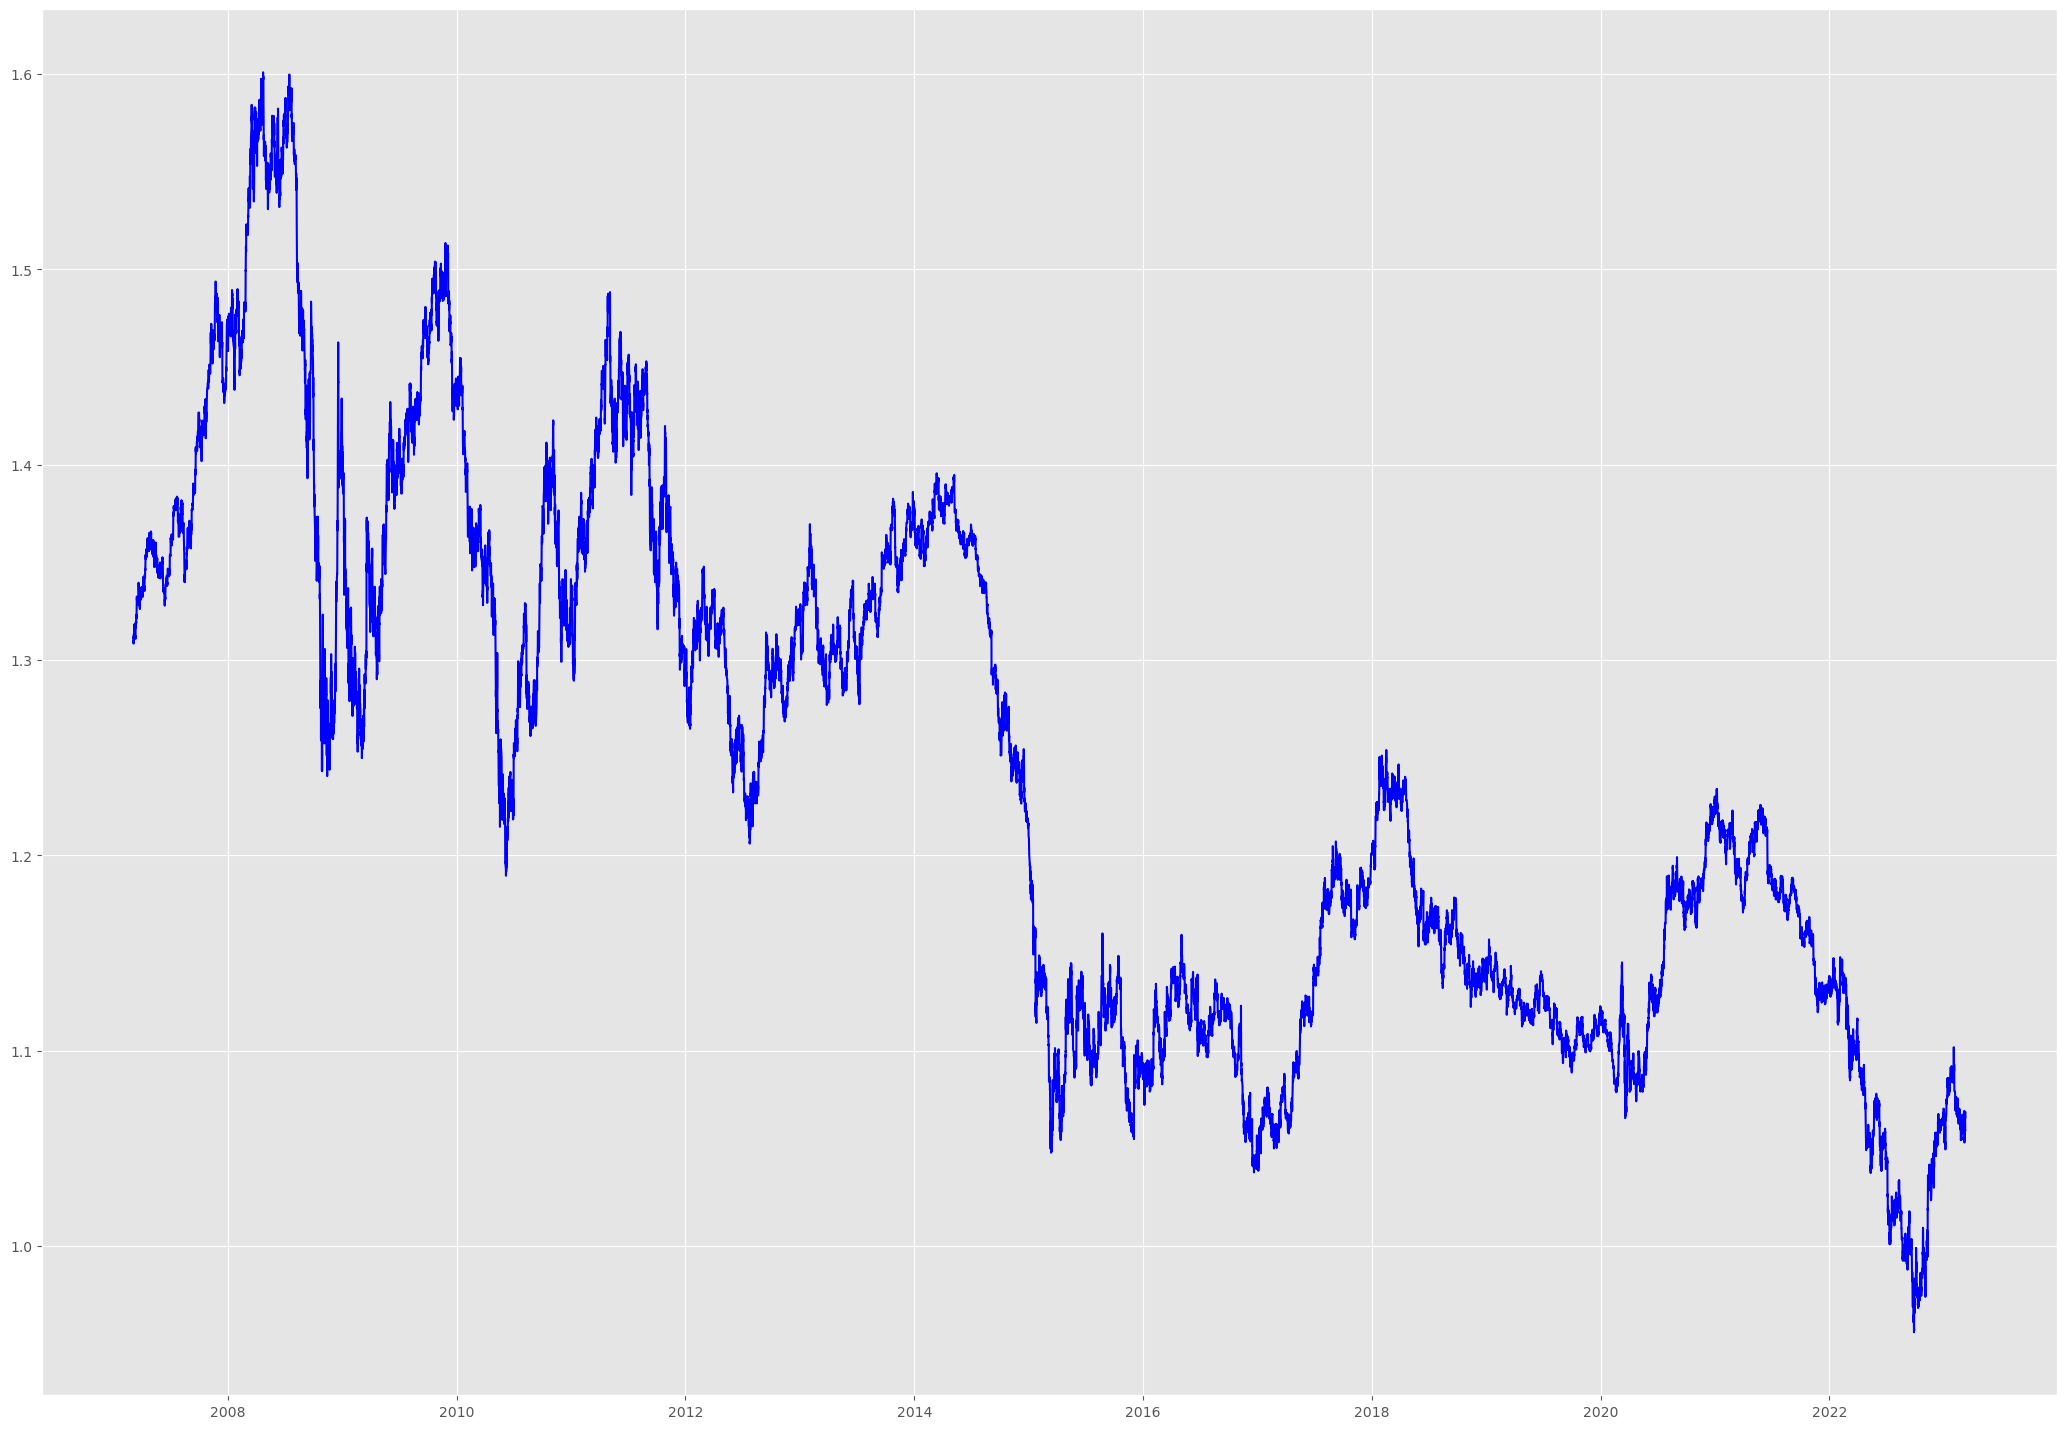

In [84]:
plt.figure(figsize=(26,18))
plt.plot(df[0]['Close'],color='blue')

In [85]:
def rsi(df,n) :
    df['diff'] = df['Close'].diff(1).dropna()
    df['gains'] = np.where(df['diff'] > 0,df['diff'],np.nan)
    df['losses'] = np.where(df['diff'] <=0 ,df['diff'], np.nan)
    df['average_gains'] = df['gains'].rolling(n, min_periods = 1).mean()
    df['average_losses'] = df['losses'].rolling(n, min_periods=1).mean()
    rs = abs(df['average_gains'] / df['average_losses'])
    df['RSI'] = 100 - (100 / (1 + rs))
    df = df.drop(['diff','gains','losses','average_gains','average_losses'], axis=1)
    return df


def ATR(df,n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low','High-PrevClose','Low-PrevClose']].max(axis = 1,skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low','High-PrevClose','Low-PrevClose'],axis=1)
    return df

In [86]:
# Strategy parameter
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

for pair in range(len(pairs_list)) :
    df[pair]['ATR']= ATR(df[pair],20)['ATR']
    df[pair]['RSI'] = rsi(df[pair],14)['RSI']
    df[pair]['average_close'] = df[pair]['Close'].rolling(5).mean()

    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')

    
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')


Pair:  EURUSD/EURUSD_H4 - EURUSD_H4 a
Pair:  AUDUSD/AUDUSD_H4 - AUDUSD_H4 a
Pair:  GBPUSD/GBPUSD_H4 - GBPUSD_H4 a
Pair:  NZDUSD/NZDUSD_H4 - NZDUSD_H4 a
Pair:  USDCAD/USDCAD_H4 - USDCAD_H4 a
Pair:  USDCHF/USDCHF_H4 - USDCHF_H4 a
Pair:  USDJPY/USDJPY_H4 - USDJPY_H4 b
Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [87]:
df[0]

,Open,High,Low,Close,Volume,ATR,diff,gains,losses,average_gains,average_losses,RSI,average_close,spread,size
Time,,,,,,,,,,,,,,,
2007-03-05 12:00:00,1.30956,1.31145,1.30723,1.30979,185987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0002,10000.0
2007-03-05 16:00:00,1.30960,1.31112,1.30833,1.30981,1025327,NaN,0.00002,0.00002,NaN,0.000020,NaN,NaN,NaN,0.0002,10000.0
2007-03-05 20:00:00,1.30979,1.30986,1.30782,1.30840,235967,NaN,-0.00141,NaN,-0.00141,0.000020,-0.001410,1.398601,NaN,0.0002,10000.0
2007-03-06 00:00:00,1.30813,1.31113,1.30798,1.31071,191415,NaN,0.00231,0.00231,NaN,0.001165,-0.001410,45.242718,NaN,0.0002,10000.0
2007-03-06 04:00:00,1.31078,1.31262,1.30923,1.31211,187099,NaN,0.00140,0.00140,NaN,0.001243,-0.001410,46.859296,1.310164,0.0002,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10 00:00:00,1.05855,1.05993,1.05791,1.05967,62976,0.002701,0.00111,0.00111,NaN,0.000914,-0.000740,55.271995,1.057946,0.0002,10000.0
2023-03-10 04:00:00,1.05967,1.06066,1.05809,1.05948,58412,0.002755,-0.00019,NaN,-0.00019,0.000914,-0.000712,56.223528,1.058424,0.0002,10000.0
2023-03-10 08:00:00,1.05946,1.06036,1.05738,1.05894,86765,0.002823,-0.00054,NaN,-0.00054,0.000914,-0.000442,67.414810,1.058840,0.0002,10000.0


In [88]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['RSI'][i-1] < 20 and df[pair]['Close'][i - 1] < df[pair]['average_close'][i - 1] \
            and df[pair]['Close'][i] >= df[pair]['average_close'][i] \
            and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['RSI'][i-1] > 80 and df[pair]['Close'][i - 1] > df[pair]['average_close'][i - 1] and df[pair]['Close'][i] <= df[pair]['average_close'][i] \
            and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

102 New Short trade at price: 1.333  On day: 2007-03-28 00:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
102 Short profit at price: 1.331 On day: 2007-03-28 16:00:00 With profit: 13.965 

332 New Long trade at price: 1.3498  On day: 2007-05-18 04:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
332 Long loss at price: 1.3474 On day: 2007-05-18 08:00:00 With loss: -14.07 

531 New Short trade at price: 1.36  On day: 2007-07-03 04:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
531 Short loss at price: 1.3614 On day: 2007-07-04 00:00:00 With loss: -15.345 

572 New Short trade at price: 1.3744  On day: 2007-07-11 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
572 Short loss at price: 1.3784 On day: 2007-07-12 04:00:00 With loss: -15.27 

1268 New Long trade at price: 1.4442  On day: 2007-12-17 00:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
1268 Long loss at price: 1.4414 On day: 2007-12-17 04:00:00 With loss: -29.1425 

1604 New Short trade at price: 1.519  On day: 2008-02-29 08:00:00 Pair: EURUSD/EURUSD_H4 - EUR

In [89]:
trade

{0: {102: {'ID': 102,
   'date_of_trade': Timestamp('2007-03-28 00:00:00'),
   'entry_price': 1.33296,
   'signal': 'Sell',
   'result': 13.965000000000005,
   'TP': 1.3313635,
   'SL': 1.3345565},
  332: {'ID': 332,
   'date_of_trade': Timestamp('2007-05-18 04:00:00'),
   'entry_price': 1.3498,
   'signal': 'Buy',
   'result': -14.069999999999583,
   'TP': 1.351007,
   'SL': 1.3485930000000002},
  531: {'ID': 531,
   'date_of_trade': Timestamp('2007-07-03 04:00:00'),
   'entry_price': 1.36,
   'signal': 'Sell',
   'result': -15.345000000000164,
   'TP': 1.3586655,
   'SL': 1.3613345000000001},
  572: {'ID': 572,
   'date_of_trade': Timestamp('2007-07-11 20:00:00'),
   'entry_price': 1.37443,
   'signal': 'Sell',
   'result': -15.270000000000783,
   'TP': 1.373103,
   'SL': 1.3757570000000001},
  1268: {'ID': 1268,
   'date_of_trade': Timestamp('2007-12-17 00:00:00'),
   'entry_price': 1.44417,
   'signal': 'Buy',
   'result': -29.14249999999918,
   'TP': 1.4468842499999999,
   'SL': 1

In [95]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({j: trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''



my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())

strategy_results_test = pd.merge(pairs_results[0],pairs_results[1],on = 'date_of_trade', how = 'outer')
strategy_results_test = strategy_results_test.sort_index()
strategy_results_test['final_res'] = strategy_results_test.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results_test['cum_res'] = strategy_results_test['final_res'].cumsum() + account_size
# print(strategy_results_test.sort_index())

# print(pairs_results.values())

# print('+++++++++++++++++++++++++')
# print(pairs_results[0])

# print('-----------------------------------------------------')
print(strategy_results_test)
print('========================================================')


strategy_results = strategy_results.sort_index()

print(strategy_results)
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size


# -------------------------------------------------------------------------------------------------------------------------------

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))



                     entry_price_x  result_x  cum_res_x  entry_price_y  \
date_of_trade                                                            
2007-03-19 00:00:00            NaN       NaN        NaN        0.79465   
2007-03-20 00:00:00            NaN       NaN        NaN        0.79769   
2007-03-28 00:00:00        1.33296    13.965   1013.965            NaN   
2007-04-16 08:00:00            NaN       NaN        NaN        0.83257   
2007-05-18 04:00:00        1.34980   -14.070    999.895            NaN   
...                            ...       ...        ...            ...   
2022-09-27 00:00:00            NaN       NaN        NaN        0.64801   
2023-01-18 16:00:00            NaN       NaN        NaN        0.69435   
2023-02-06 04:00:00            NaN       NaN        NaN        0.69239   
2023-02-07 16:00:00        1.07191    16.535    862.345            NaN   
2023-02-27 12:00:00            NaN       NaN        NaN        0.67290   

                     result_y  cum_re

C:\Users\Win10\AppData\Local\Temp\ipykernel_2216\1714649921.py:24: FutureWarning: Passing 'suffixes' which cause duplicate columns {'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_2216\1714649921.py:24: FutureWarning: Passing 'suffixes' which cause duplicate columns {'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_2216\1714649921.py:24: FutureWarning: Passing 'suffixes' which cause duplicate columns {'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Strategy returns: -10554


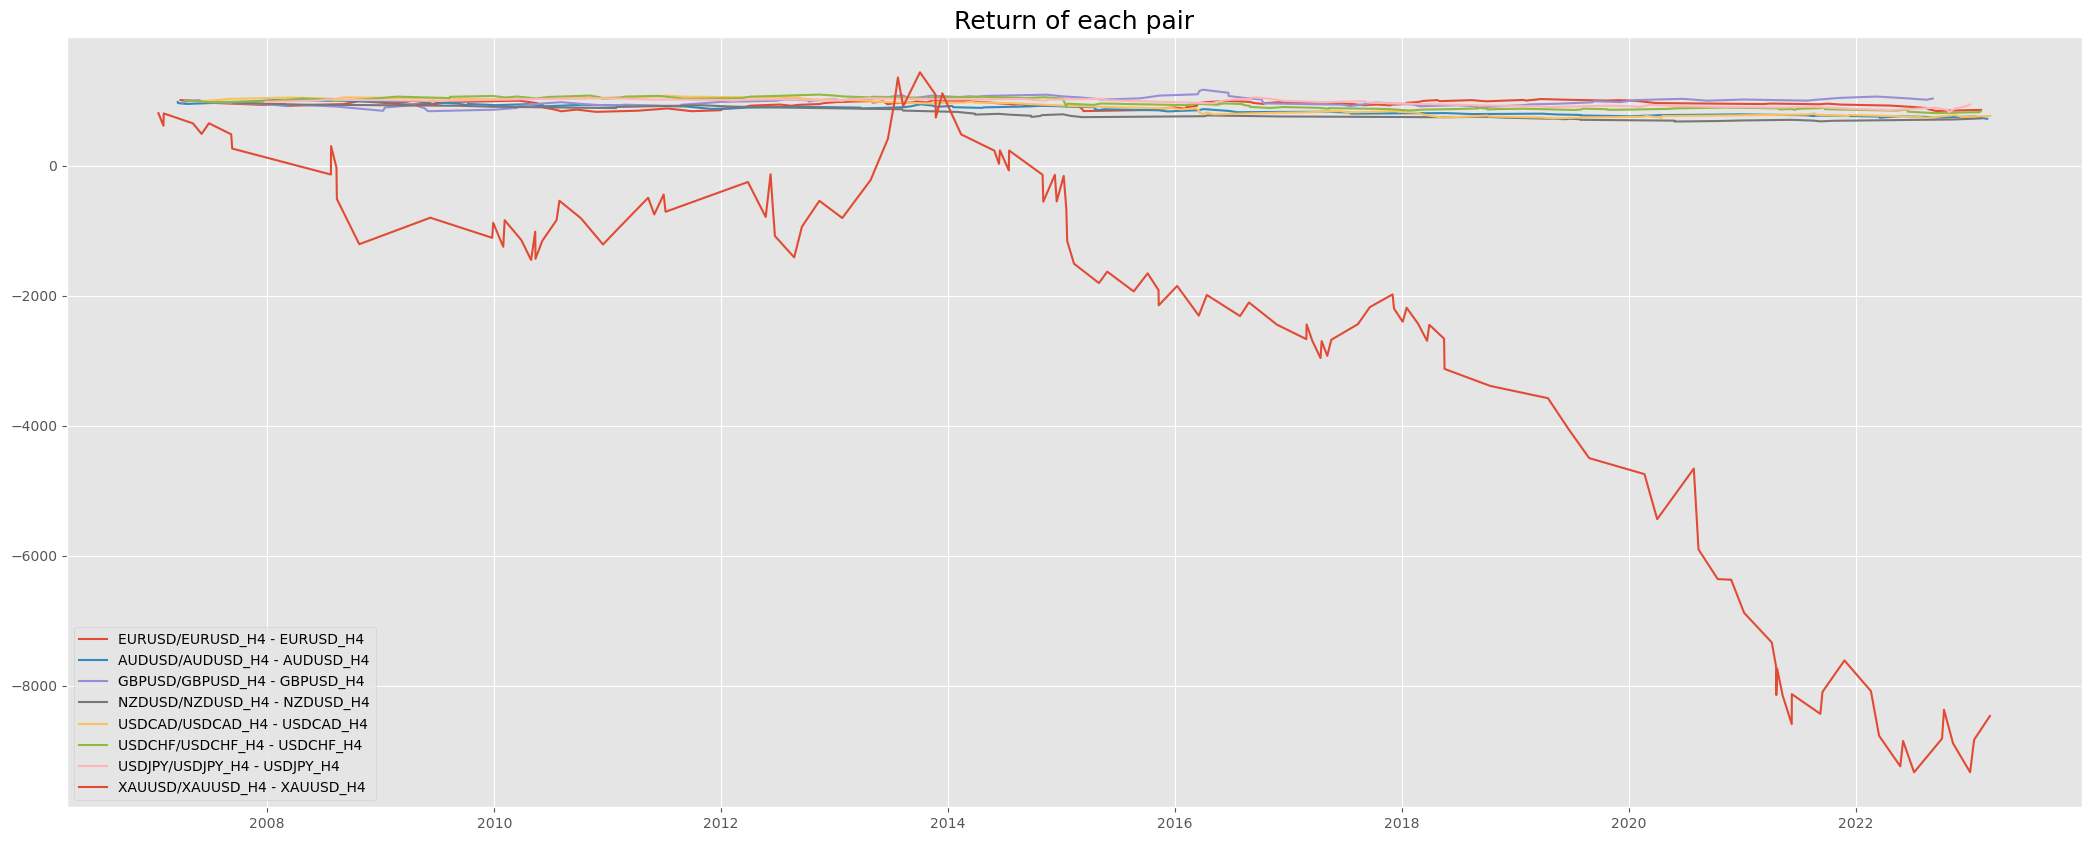

In [91]:
plt.figure(figsize= (26,10))
for pair in range(len(pairs_list)) :
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])

plt.legend()
plt.title('Return of each pair', fontsize =18)

print('Strategy returns:', round(strategy_results['cum_res'][-1]) - account_size)

In [92]:
strategy_results.head(50)

,entry_price_x,result_x,cum_res_x,entry_price_y,result_y,cum_res_y,entry_price_x,result_x,cum_res_x,entry_price_y,...,result_y,cum_res_y,entry_price_x,result_x,cum_res_x,entry_price_y,result_y,cum_res_y,final_res,cum_res
date_of_trade,,,,,,,,,,,,,,,,,,,,,
2007-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,624.598,-188.5575,811.4425,-188.5575,811.4425
2007-02-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,652.340,-192.9350,618.5075,-192.9350,618.5075
2007-02-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,655.387,189.3275,807.8350,189.3275,807.8350
2007-03-19 00:00:00,NaN,NaN,NaN,0.79465,-16.2125,983.7875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.2125,791.6225
2007-03-20 00:00:00,NaN,NaN,NaN,0.79769,-16.7400,967.0475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.7400,774.8825
2007-03-28 00:00:00,1.33296,13.9650,1013.9650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.9650,788.8475
2007-04-03 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.97390,-24.2125,975.7875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.2125,764.6350
2007-04-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.8525,1010.8525,NaN,NaN,NaN,NaN,NaN,NaN,10.8525,775.4875
2007-04-16 08:00:00,NaN,NaN,NaN,0.83257,-13.6250,953.4225,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.6250,761.8625


In [93]:
pairs_results[0]

,entry_price,result,cum_res
date_of_trade,,,
2007-03-28 00:00:00,1.33296,13.9650,1013.9650
2007-05-18 04:00:00,1.34980,-14.0700,999.8950
2007-07-03 04:00:00,1.36000,-15.3450,984.5500
2007-07-11 20:00:00,1.37443,-15.2700,969.2800
2007-12-17 00:00:00,1.44417,-29.1425,940.1375
...,...,...,...
2022-06-30 12:00:00,1.04686,-21.2225,907.5750
2022-08-16 12:00:00,1.01731,-17.2925,890.2825
2022-08-23 12:00:00,0.99733,-19.3925,870.8900


In [94]:
profits

{0: [13.965000000000005,
  12.600000000000167,
  26.740000000000432,
  46.12499999999886,
  8.689999999999866,
  28.597500000000277,
  20.652499999999964,
  26.319999999999457,
  17.19250000000039,
  35.080000000000446,
  15.057499999999502,
  21.284999999999556,
  16.19749999999898,
  15.687500000000965,
  17.87500000000031,
  15.955000000000608,
  13.272500000000909,
  13.567499999999955,
  14.082500000000886,
  16.46749999999897,
  15.579999999999261,
  17.90500000000006,
  15.925000000000855,
  13.119999999999576,
  12.86249999999911,
  15.510000000000579,
  19.26749999999955,
  9.302500000001103,
  7.302499999999103,
  18.4699999999991,
  27.797499999999477,
  10.7900000000003,
  20.94999999999936,
  24.140000000001162,
  25.62249999999966,
  18.279999999999188,
  14.02749999999986,
  18.009999999999195,
  11.582500000000051,
  20.280000000001188,
  10.855000000000503,
  10.564999999999936,
  9.82999999999934,
  18.482500000000847,
  14.089999999999714,
  15.78250000000092,
  12.4